# Preliminary analysis of model data

Access and plot data from Pouya. 

`wrfoutPostprocessed_d03_T2_hourly.nc`: contains hourly air temperature for the WRF-UCM domain over Los Angeles for July 2018 
(start time is in the file) when a high-impact heatwave occurred. This is the control or current urban land scenario (representing the reality).

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from scipy.stats import linregress

data_dir = "../../data/"

In [2]:
ds = xr.open_dataset(data_dir + 'urbanMicroClimate/wrfoutPostprocessed_d03_T2_hourly.nc')
ds

<xarray.Dataset>
Dimensions:  (Time: 792, south_north: 339, west_east: 384)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    T2       (Time, south_north, west_east) float32 ...
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-06-30_00:00:00
    WEST-EAST_GRID_DIMENSION:        385
    SOUTH-NORTH_GRID_DIMENSION:      340
    BOTTOM-TOP_GRID_DIMENSION:       33
    DX:                              444.44446
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Thu Dec  8 21:14:13 2022: ncrcat wrfout_...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...

In [3]:
t2 = ds['T2']
t2

<xarray.DataArray 'T2' (Time: 792, south_north: 339, west_east: 384)>
[103099392 values with dtype=float32]
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   TEMP at 2 M
    units:         K
    stagger:       
    coordinates:   XLONG XLAT XTIME
    cell_methods:  Time: mean

## Plot first time step

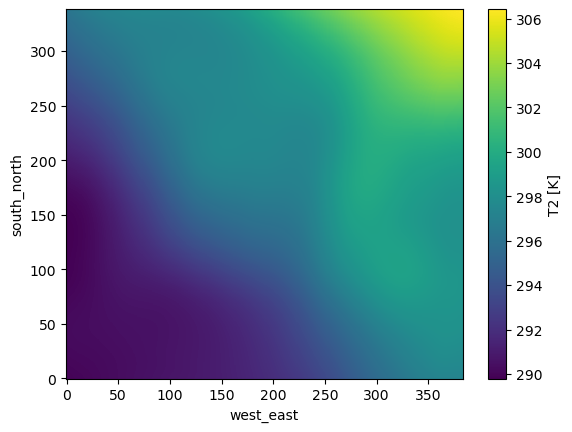

In [4]:
ds['T2'].isel(Time = 0).plot()

## Add lat/lon coordinates

In [5]:
ds_idx = xr.open_dataset(data_dir + 'urbanMicroClimate/wrfout_d03_2018-06-30_00_00_00')
ds_idx

<xarray.Dataset>
Dimensions:    (Time: 9, south_north: 339, west_east: 384)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 ...
    XLONG      (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/28)
    Times      (Time) |S19 ...
    LU_INDEX   (Time, south_north, west_east) float32 ...
    Q2         (Time, south_north, west_east) float32 ...
    T2         (Time, south_north, west_east) float32 ...
    PSFC       (Time, south_north, west_east) float32 ...
    U10        (Time, south_north, west_east) float32 ...
    ...         ...
    GLW        (Time, south_north, west_east) float32 ...
    UST        (Time, south_north, west_east) float32 ...
    AHFLUX     (Time, south_north, west_east) float32 ...
    IRRFRC     (Time, south_north, west_east) float32 ...
    SNOWC      (Time, south_north, west_east) float32 ...
    SR         (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-06-30_00:00:00
    SIMULATION_START_DATE:           2018-06-30_00:00:00
    WEST-EAST_GRID_DIMENSION:        385
    SOUTH-NORTH_GRID_DIMENSION:      340
    BOTTOM-TOP_GRID_DIMENSION:       33
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [6]:
lat = ds_idx.coords['XLAT'].values
lat.shape # why is there a time dimension of length 9 here?

(9, 339, 384)

In [7]:
[(lat[0, :, :] == lat[i, :, :]).all() for i in range(9)] # values are equal across the 9 time dimensions

# maybe the other variables in the ds have different values over time? but lat lon are the same

[True, True, True, True, True, True, True, True, True]

In [8]:
# Add lat/lon coords to t2 dataarray
t2.coords['lat'] = (('south_north', 'west_east'), ds_idx.coords['XLAT'].values[0, :, :])
t2.coords['lon'] = (('south_north', 'west_east'), ds_idx.coords['XLONG'].values[0, :, :])
t2

<xarray.DataArray 'T2' (Time: 792, south_north: 339, west_east: 384)>
[103099392 values with dtype=float32]
Coordinates:
    lat      (south_north, west_east) float32 33.1 33.1 33.1 ... 34.76 34.76
    lon      (south_north, west_east) float32 -118.7 -118.6 ... -117.2 -117.2
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   TEMP at 2 M
    units:         K
    stagger:       
    coordinates:   XLONG XLAT XTIME
    cell_methods:  Time: mean

## Plot lat/lon

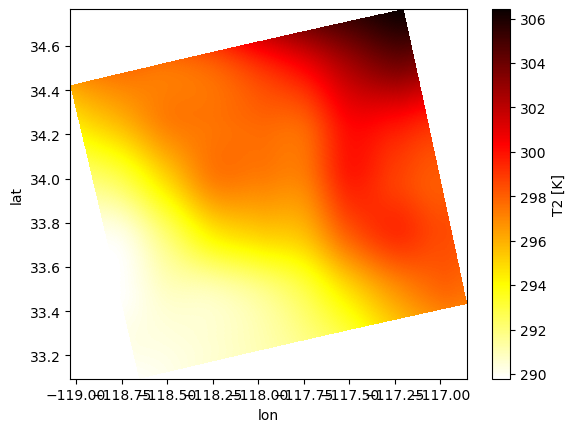

In [9]:
t2.isel(Time=0).plot(
    x='lon', y='lat',
    cmap = 'hot_r'
    # cmap = 'hot'
    # cmap = 'YlOrRd'
)

## Show census polygons

### Census tract level

In [3]:
tiger_data_dir = data_dir + "tiger/tl_2019_06_tract/"

df_tract = gpd.read_file(tiger_data_dir + "tl_2019_06_tract.shp")

df_tract_la = df_tract[df_tract["COUNTYFP"] == '037']

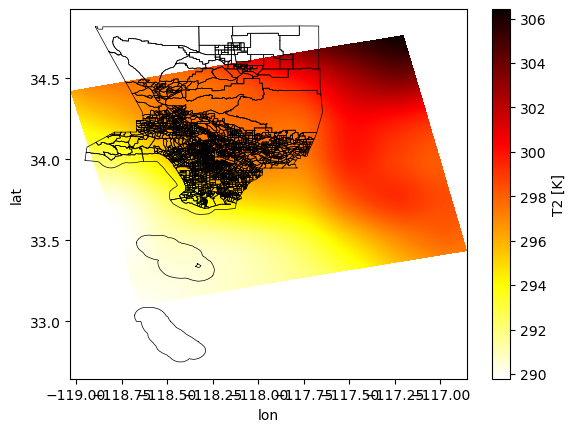

In [11]:
t2.isel(Time=0).plot(
    x='lon', y='lat',
    cmap = 'hot_r'
)

for tract in df_tract_la["geometry"]:
# for tract in df_tract["geometry"]:
    if hasattr(tract, 'geoms'):
        for geom in tract.geoms:
            plt.plot(*geom.exterior.xy, color='k', linewidth=0.5)
    else:
        plt.plot(*tract.exterior.xy, c='k', linewidth=0.5)

### Show some survey values

In [12]:
df_eco = pd.read_csv(data_dir+"eco-apartheid/LA_eco_data.csv")

df_eco["GEOID"] = df_eco["GEOID"].transform(lambda x: "0" + str(x)) # add a leading zero

df_merged = pd.merge(df_tract, df_eco, how="right", on="GEOID") # merge with block group geometries
df_merged.shape

(2735, 46)

In [32]:
df_merged.columns

Index(['STATEFP_x', 'COUNTYFP_x', 'TRACTCE_x', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND_x', 'AWATER_x', 'INTPTLAT', 'INTPTLON',
       'geometry', 'STATEFP_y', 'COUNTYFP_y', 'TRACTCE_y', 'AFFGEOID',
       'NAME_y', 'LSAD', 'ALAND_y', 'AWATER_y', 'metro', 'county_fips',
       'temp06', 'temp07', 'temp08', 'heat', 'Medicaid.enrollment.gap',
       'Electricity.burden', 'Gas.burden', 'heat_decile', 'elec_decile',
       'heat_vulnerability', 'e.0.', 'Percent.non.white', 'Percent.black',
       'Essential.worker.rate', 'Housing.cost', 'police_killings', 'ej',
       'ej_cancer', 'eco_apartheid', 'e0_demean_city', 'SVI', 'redlining',
       'ADI'],
      dtype='object')

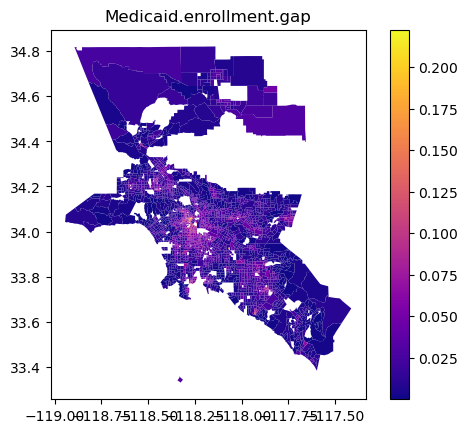

In [14]:
var = "Medicaid.enrollment.gap" #"eco_apartheid"  # "ADI" #"redlining" #"Electricity.burden" #"Essential.worker.rate" #"Housing.cost"

df_merged.plot(
    column = var, 
    missing_kwds={'color': 'grey'},
    cmap="plasma",
    legend=True
    )

plt.title(var)
plt.show()

In [15]:
# what's going on here with the values being greater than 1?
# Nick said replace vals>1 with NAN
df_elec = df_merged.copy()
df_elec['Electricity.burden'][df_elec['Electricity.burden'] > 1] = np.NAN
df_elec['Gas.burden'][df_elec['Gas.burden'] > 1] = np.NAN

C:\Users\corak\AppData\Local\Temp\ipykernel_36804\3050689810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elec['Electricity.burden'][df_elec['Electricity.burden'] > 1] = np.NAN
C:\Users\corak\AppData\Local\Temp\ipykernel_36804\3050689810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elec['Gas.burden'][df_elec['Gas.burden'] > 1] = np.NAN


<AxesSubplot:>

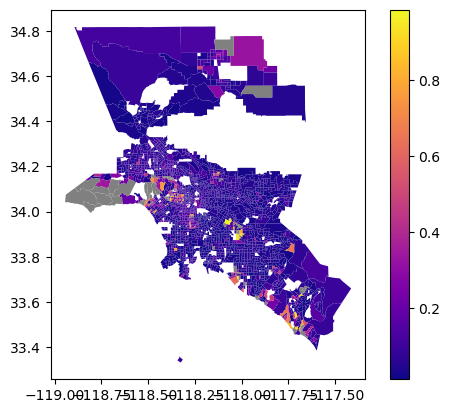

In [16]:
df_elec.plot(
    column = "Electricity.burden", 
    missing_kwds={'color': 'grey'},
    cmap="plasma",
    legend=True
    )

### Census tract areas

In [17]:
# Reproject to be able to get area in meters (instead of lat/lon)
# df_km = df_merged.copy()
df_km = df_tract_la.copy()

# Which reprojection to use?
# df_km = df_km.to_crs({'init': 'epsg:3857'})
df_km = df_km.to_crs({'proj':'cea'})

df_km["area_km2"] = df_km['geometry'].area/ 10**6

In [18]:
df_km["area_km2"].describe()

count    2346.000000
mean        5.245257
std        45.097530
min         0.069960
25%         0.603562
50%         1.040804
75%         1.898167
max      1435.823478
Name: area_km2, dtype: float64

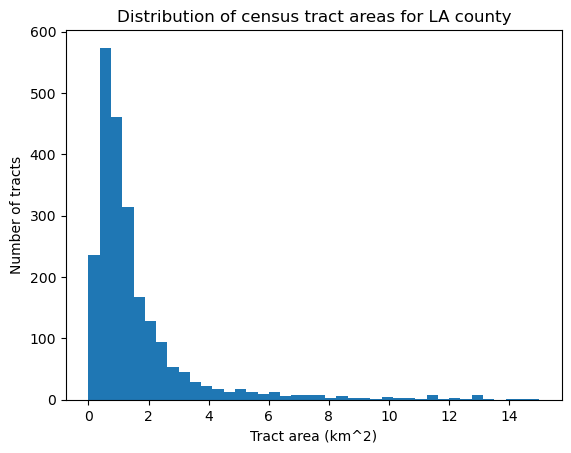

In [19]:
plt.hist(df_km["area_km2"], bins=40, range=[0, 15])

plt.title("Distribution of census tract areas for LA county")
plt.xlabel("Tract area (km^2)")
plt.ylabel("Number of tracts")
plt.show()

### Census block group
I think this is incorrect-- eco-apartheid index is at census tract not block group level?
But below just shows the distribution of areas for block groups (smaller than census tracts)

In [20]:
# read in shape file for block groups
tiger_data_dir = data_dir + "tiger/tl_2022_06_bg/"
df_bg = gpd.read_file(tiger_data_dir + "tl_2022_06_bg.shp")
df_bg_la = df_bg[df_bg["COUNTYFP"] == '037']

In [21]:
df_bg_la = df_bg_la.to_crs({'proj':'cea'})
df_bg_la["area_km2"] = df_bg_la['geometry'].area/ 10**6

In [22]:
df_bg_la["area_km2"].describe()

count    6591.000000
mean        1.866335
std        23.595728
min         0.021430
25%         0.205121
50%         0.323032
75%         0.545244
max      1032.870057
Name: area_km2, dtype: float64

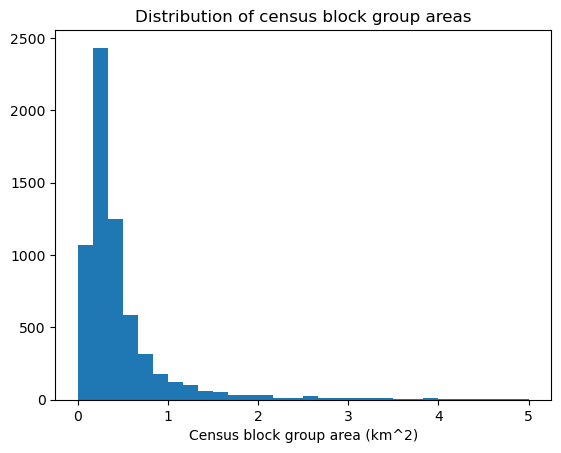

In [23]:
plt.hist(df_bg_la["area_km2"], bins=30, range=[0, 5])
plt.title("Distribution of census block group areas")
plt.xlabel("Census block group area (km^2)")
plt.show()

## Initial merge and analyze

Starting with just LA county from socio data (can add more counties later)

- (need to reproject) -- actually don't need to?? lat/lon points merge fine with polygons?
- for each polygon, average the climate values in that polygon
- which climate values: 
-- max over whole time period?
-- average of hottest 10 values?

Notes on merging:
- climate data is in xarray format from metcdf
- survey data is geopandas geodataframe-- easier to reproject
- get CRS info from climate xarray --> apply to survey gdf

In [24]:
# make geodataframe of points from the climate data grid
df_t2 = t2.isel(Time=0).to_dataframe().reset_index()
df_t2_avg = t2.mean(dim = "Time").to_dataframe().reset_index()
df_t2_max = t2.max(dim = "Time").to_dataframe().reset_index()

In [25]:
gdf_t2 = gpd.GeoDataFrame(
    data = {
        "T2_t0" : df_t2.T2, 
        "T2_avg" : df_t2_avg.T2,
        "T2_max" : df_t2_max.T2
    },
    geometry=gpd.points_from_xy(df_t2.lon, df_t2.lat)
)

In [26]:
# gdf_all = df_merged.sjoin(gdf_t2)
gdf_all = df_elec.sjoin(gdf_t2)
# gdf_all.head(2)

c:\Users\corak\anaconda3\envs\masters\lib\site-packages\geopandas\geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [27]:
varlist = ['T2_t0', 'T2_avg', 'T2_max', *df_eco.columns[15:]]

gdf_all_pts = gdf_all.groupby("GEOID")[varlist].aggregate(np.mean)
gdf_all_pts = pd.merge(df_tract, gdf_all_pts, how="left", on="GEOID")
gdf_all_pts['geometry'] = gdf_all_pts.centroid
# gdf_all_pts.head(2)

C:\Users\corak\AppData\Local\Temp\ipykernel_36804\3234371251.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_all_pts['geometry'] = gdf_all_pts.centroid


### Climate plots

plot climate point values, to make sure the merge worked

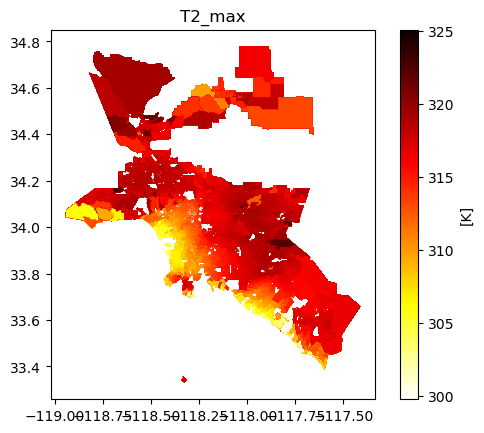

In [28]:
# plot with polygons?
var = 'T2_max'
gdf_all.plot(column = var, cmap='hot_r', legend=True, legend_kwds = {'label' : '[K]'})
plt.title(var)
plt.show()

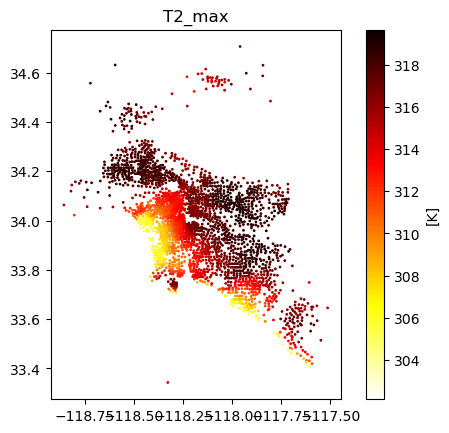

In [29]:
# plots with points

var = 'T2_max'

# ax = plt.axes()
# ax.set_facecolor('grey')

gdf_all_pts.plot(
    # ax = ax,
    column = var, 
    markersize = 1, 
    cmap='hot_r', 
    legend=True, 
    legend_kwds = {'label' : '[K]'},
    )

plt.title(var)
plt.show()

### Scatter plots

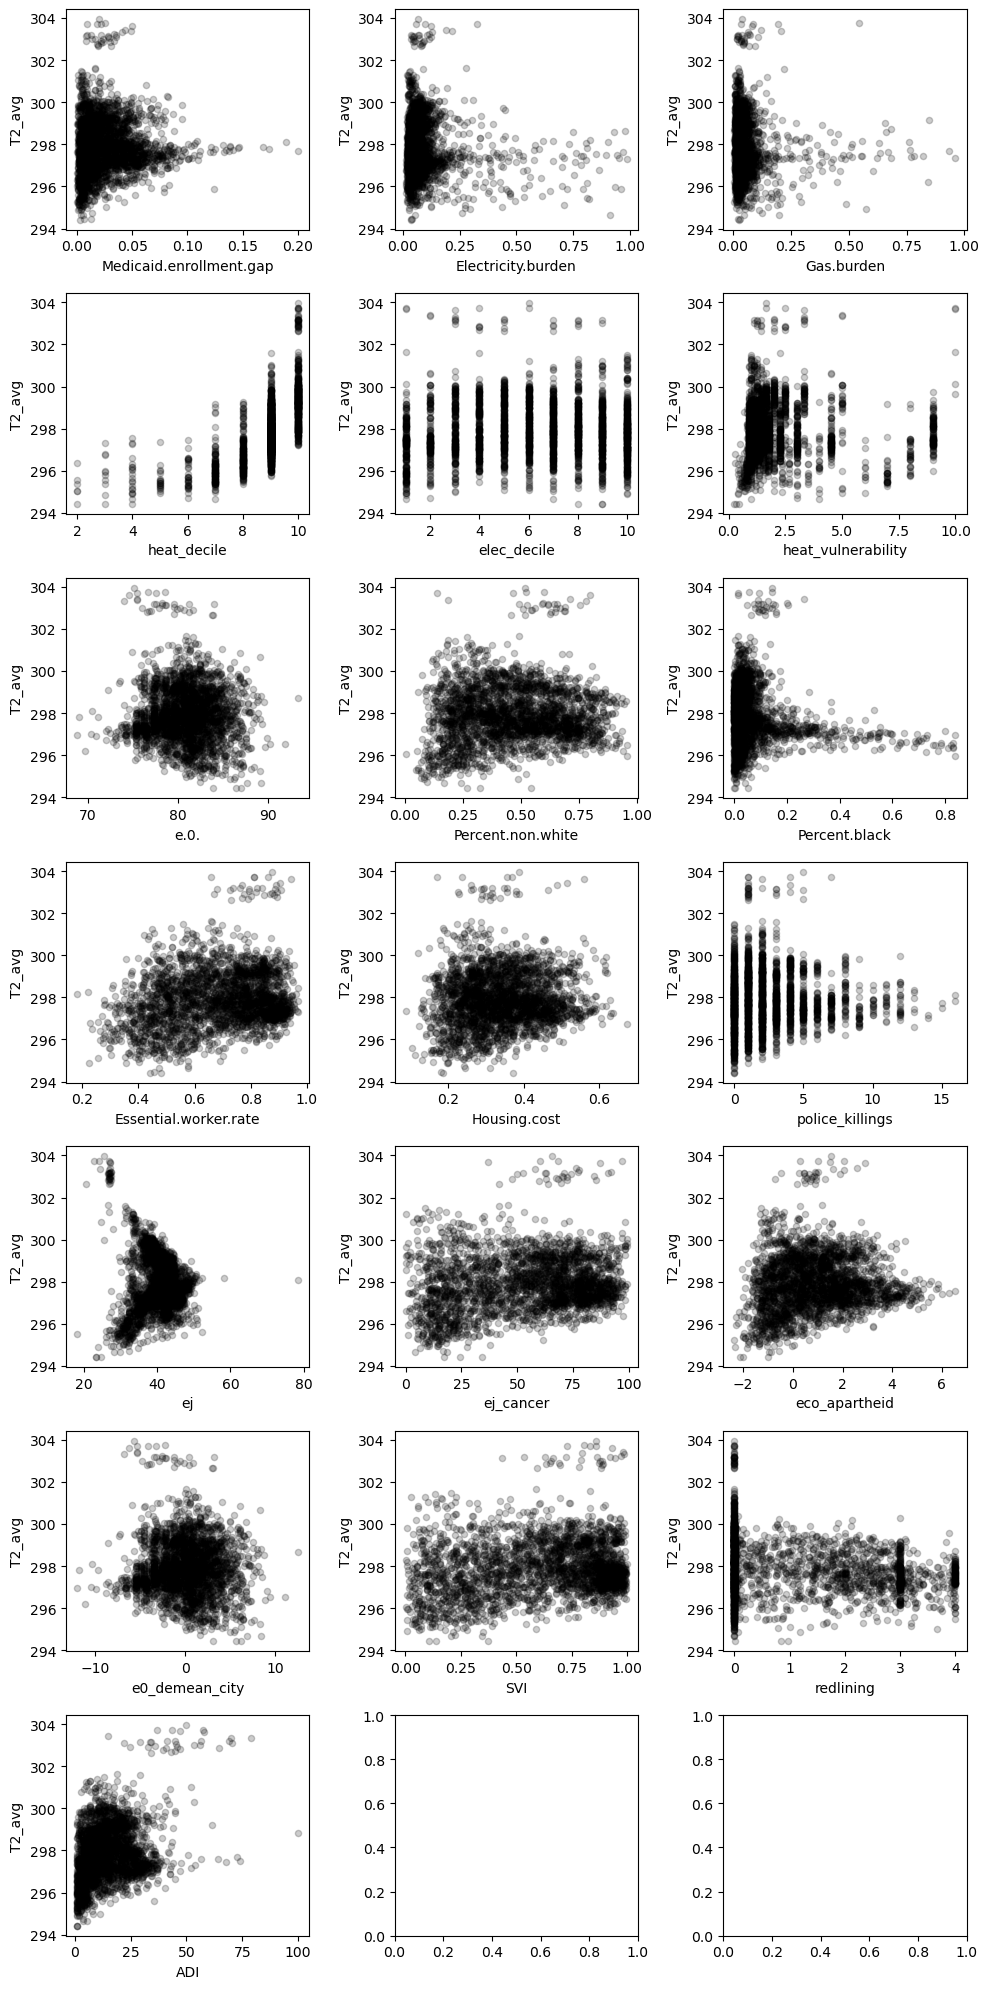

In [33]:
T_var = 'T2_avg'

fig, axes = plt.subplots(nrows=7, ncols=3, figsize = (10, 20))

for (ax, var) in zip(axes.ravel()[0:19], varlist[3:]):
    gdf_all_pts.plot(kind="scatter", ax=ax, x = var, y = T_var, color='k', alpha=0.2)

plt.tight_layout()

### Regressions

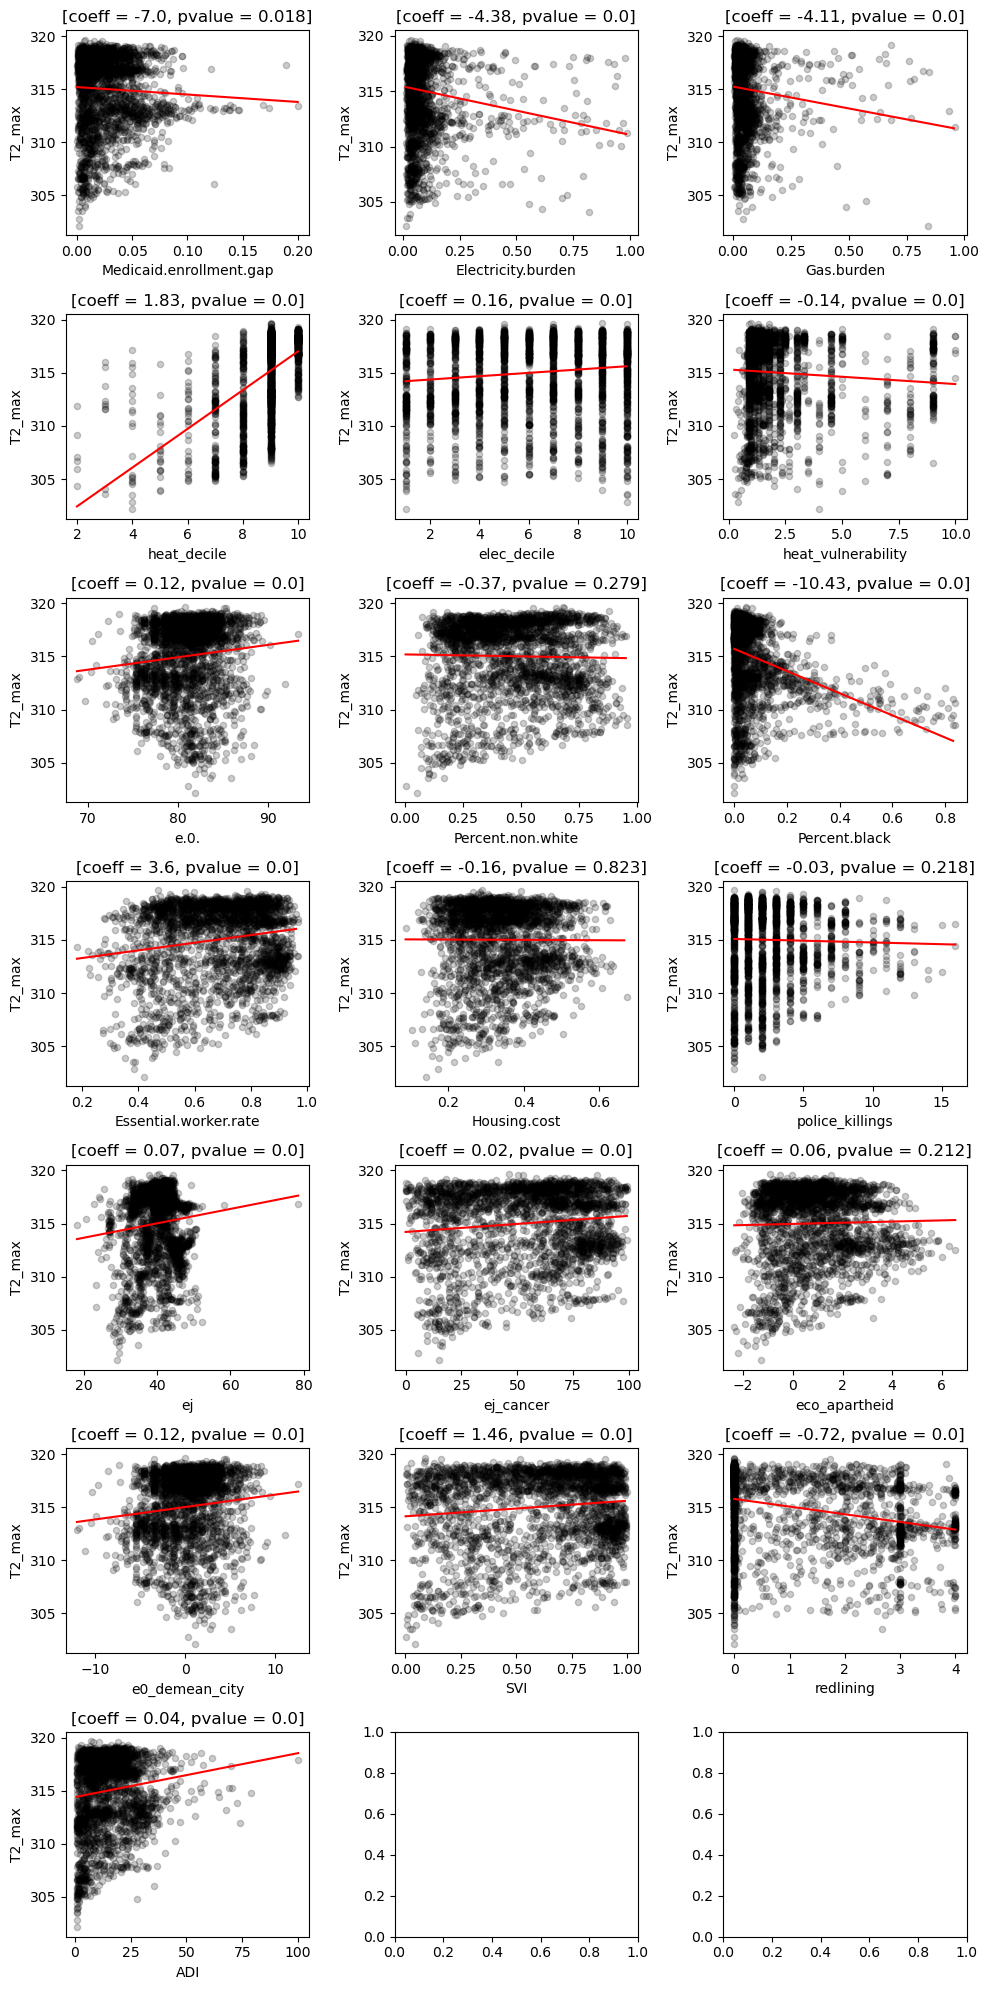

In [31]:
vary = "T2_max"
datay = gdf_all_pts[vary]

fig, axes = plt.subplots(nrows=7, ncols=3, figsize = (10, 20))

for (ax, varx) in zip(axes.ravel()[0:19], varlist[3:]):

    datax = gdf_all_pts[varx]
    nan_mask = ~np.isnan(datax) & ~np.isnan(datay)
    res = linregress(datax[nan_mask], datay[nan_mask])

    m, b = res.slope, res.intercept
    pvalue = res.pvalue

    min_x, max_x = min(datax), max(datax)
    reg_x = np.arange(min_x, max_x, 0.01)
    reg_line = [m*x + b for x in reg_x]

    gdf_all_pts.plot(kind="scatter", ax=ax, x = varx, y = vary, style='o', c='k', alpha=0.2)
    ax.plot(reg_x, reg_line, c='r')

    ax.set_title(f"[coeff = {round(m, 2)}, pvalue = {round(pvalue, 3)}]")

plt.tight_layout()